# 1 - Analyse exploratoire des données

## 1.1 - Importation des bibliothèques

In [1]:
from typing import dataclass_transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import fonctions as f
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

## 1.2 - Chargement du dataset

In [2]:
dataset_filtered = pd.read_csv('dataset_filtered_co2.csv')

In [3]:
dataset_filtered = dataset_filtered.drop(columns=['SiteEnergyUse(kBtu)'])

# 2. Modélisations Cible 1

In [4]:
def prepare_data(dataset, target_col='TotalGHGEmissions', test_size=0.3, random_state=1221):
    """
    Prépare les données en séparant les variables explicatives et la cible.

    Parameters:
    -----------
    dataset : DataFrame
        Jeu de données complet
    target_col : str, default='TotalGHGEmissions'
        Nom de la colonne cible
    test_size : float, default=0.3
        Proportion des données à utiliser pour le test
    random_state : int, default=1221
        Graine aléatoire pour la reproductibilité

    Returns:
    --------
    X_train, X_test, y_train, y_test : array-like
        Ensembles d'entraînement et de test pour les variables et la cible
    """
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_and_evaluate(model, X_train, y_train, X_test, y_test, target_type='brut'):
    """
    Entraîne et évalue un modèle avec gestion cohérente de y.

    Parameters:
    -----------
    model : estimator
        Modèle à entraîner
    X_train, y_train : array-like
        Données d'entraînement
    X_test, y_test : array-like
        Données de test
    target_type : str, default='brut'
        Type de transformation appliquée à la cible ('log' ou 'brut')

    Returns:
    --------
    model : estimator
        Modèle entraîné
    y_pred : array
        Prédictions sur l'ensemble de test
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    print_scores(y_test, y_pred, f"Modèle {target_type}")
    return model, y_pred

def build_model(model_type='rf', params=None, grid_search=False, target_transform='brut'):
    """
    Construit un pipeline avec gestion des transformations.

    Parameters:
    -----------
    model_type : str, default='rf'
        Type de modèle à utiliser
    params : dict, default=None
        Paramètres à appliquer au modèle
    grid_search : bool, default=False
        Indique si une recherche par grille doit être effectuée
    target_transform : str, default='brut'
        Type de transformation pour la cible ('log' ou 'brut')

    Returns:
    --------
    pipeline : estimator
        Pipeline de modèle configuré
    """
    # Définition du modèle de base selon le type
    if model_type == 'dummy':
        base_model = DummyRegressor(strategy='mean')
    elif model_type == 'linear':
        base_model = LinearRegression()
    elif model_type == 'ridge':
        base_model = Ridge(random_state=1221)
    elif model_type == 'lasso':
        base_model = Lasso(random_state=1221)
    elif model_type == 'svr':
        base_model = SVR()
    elif model_type == 'rf':
        base_model = RandomForestRegressor(random_state=1221)
    elif model_type == 'xgb':
        base_model = XGBRegressor(random_state=1221)
    elif model_type == 'lgbm':
        base_model = LGBMRegressor(random_state=1221)
    else:
        raise ValueError(f"Type de modèle non reconnu: {model_type}")

    # Application de la transformation logarithmique si demandée
    if target_transform == 'log':
        model = TransformedTargetRegressor(
            regressor=base_model,
            func=np.log1p,
            inverse_func=np.expm1
        )
    else:
        model = base_model

    # Création du pipeline avec standardisation
    pipeline = Pipeline([
        ("preprocessing", StandardScaler()),
        ("modele", model)
    ])

    scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'r2': 'r2'}

    # Application des paramètres ou grid search
    if params:
        if grid_search:
            return GridSearchCV(
                pipeline,
                params,
                cv=5,
                scoring=scoring,
                refit='rmse',
                n_jobs=-1
            )
        else:
            # Configuration des paramètres en fonction du type de modèle et de la transformation
            if target_transform == 'log' and model_type in ['linear', 'ridge', 'lasso', 'svr']:
                pipeline.set_params(**{f"modele__regressor__{k}": v for k, v in params.items()})
            else:
                pipeline.set_params(**{f"{k}": v for k, v in params.items()})

    return pipeline

def print_scores(y_true, y_pred, nom_mod):
    """
    Affiche les métriques avec formatage amélioré

    Parameters:
    -----------
    y_true : array-like
        Valeurs réelles
    y_pred : array-like
        Valeurs prédites
    nom_mod : str
        Nom du modèle pour l'affichage
    """
    quant_75 = np.quantile(y_true, 0.75)
    idx_normal = y_true <= quant_75
    idx_outlier = y_true > quant_75

    print(f"\n=== {nom_mod.upper()} ===")
    print(f"MAE global: {mean_absolute_error(y_true, y_pred):.2f}")
    print(f"RMSE global: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
    print(f"R2 global: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE normal: {mean_absolute_error(y_true[idx_normal], y_pred[idx_normal]):.2f}")
    print(f"MAE outliers: {mean_absolute_error(y_true[idx_outlier], y_pred[idx_outlier]):.2f}")

def print_scores_cv(model, X, y, cv=5):
    maes = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    rmses = -cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    r2s = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1)
    print("\n--- Cross-Validation ---")
    print(f"MAE (CV): {maes.mean():.2f} ± {maes.std():.2f}")
    print(f"RMSE (CV): {rmses.mean():.2f} ± {rmses.std():.2f}")
    print(f"R2 (CV): {r2s.mean():.4f} ± {r2s.std():.4f}")

In [5]:
# Préparation des données
X_train, X_test, y_train, y_test = prepare_data(dataset_filtered)

In [6]:
# 1) Dummy Regressor
model_dummy = build_model(model_type='dummy')

model_dummy.fit(X_train, y_train)
y_pred_dummy = model_dummy.predict(X_test)

print_scores(y_test, y_pred_dummy, "Modèle Dummy (moyenne)")
print_scores_cv(model_dummy, X_train, y_train)

# 2) Linear Regression

model_linear = build_model(model_type='linear')
print_scores_cv(model_linear, X_train, y_train)
trained_linear, pred_linear = train_and_evaluate(model_linear, X_train, y_train, X_test, y_test, target_type="Régression Linéaire")


# 3) Ridge/Lasso

model_ridge = build_model(model_type='ridge')
print_scores_cv(model_ridge, X_train, y_train)
trained_ridge, pred_ridge = train_and_evaluate(model_ridge, X_train, y_train, X_test, y_test, target_type="Ridge")

model_lasso = build_model(model_type='lasso')
print_scores_cv(model_lasso, X_train, y_train)
trained_lasso, pred_lasso = train_and_evaluate(model_lasso, X_train, y_train, X_test, y_test, target_type="Lasso")

# 4) SVR

model_svr = build_model(model_type='svr')
print_scores_cv(model_svr, X_train, y_train)
trained_svr, pred_svr = train_and_evaluate(model_svr, X_train, y_train, X_test, y_test, target_type="SVR")

# 5) Random Forest

# Meilleurs paramètres RF: {'modele__max_depth': 10, 'modele__max_features': None, 'modele__min_samples_leaf': 2, 'modele__n_estimators': 500}

params_rf = {
    "modele__n_estimators": [500],
    "modele__max_depth": [10],
    "modele__min_samples_leaf": [2],
    "modele__max_features": [None]
}

model_rf = build_model(model_type='rf', params=params_rf, grid_search=True)
trained_rf, pred_rf = train_and_evaluate(model_rf, X_train, y_train, X_test, y_test, target_type="Random Forest")

for score in ['rmse', 'mae', 'r2']:
    arr = trained_rf.cv_results_[f"mean_test_{score}"]
    arr_std = trained_rf.cv_results_[f"std_test_{score}"]
    best_idx = trained_rf.best_index_
    best_mean = abs(arr[best_idx]) if score != 'r2' else arr[best_idx]
    print(f"{score.upper()} (CV): {best_mean:.3f} ± {arr_std[best_idx]:.3f}")


# 6) XGBoost

# Meilleurs paramètres XGB: {'modele__colsample_bytree': 1, 'modele__learning_rate': 0.01, 'modele__max_depth': 4, 'modele__n_estimators': 500, 'modele__reg_alpha': 0.1, 'modele__reg_lambda': 1, 'modele__subsample': 0.6}

params_xgb = {
    'modele__n_estimators': [500],
    'modele__max_depth': [4],
    'modele__learning_rate': [0.01],
    'modele__subsample': [0.6],
    'modele__colsample_bytree': [1],
    'modele__reg_alpha': [0.1],
    'modele__reg_lambda': [1],
}

model_xgb = build_model(model_type='xgb', params=params_xgb, grid_search=True)
trained_xgb, pred_xgb = train_and_evaluate(model_xgb, X_train, y_train, X_test, y_test, target_type="XGBoost")

for score in ['rmse', 'mae', 'r2']:
    arr = trained_xgb.cv_results_[f"mean_test_{score}"]
    arr_std = trained_xgb.cv_results_[f"std_test_{score}"]
    best_idx = trained_xgb.best_index_
    best_mean = abs(arr[best_idx]) if score != 'r2' else arr[best_idx]
    print(f"{score.upper()} (CV): {best_mean:.3f} ± {arr_std[best_idx]:.3f}")


=== MODÈLE DUMMY (MOYENNE) ===
MAE global: 102.24
RMSE global: 158.55
R2 global: -0.0001
MAE normal: 67.52
MAE outliers: 206.38

--- Cross-Validation ---
MAE (CV): 98.23 ± 6.05
RMSE (CV): 142.38 ± 15.95
R2 (CV): -0.0140 ± 0.0222

--- Cross-Validation ---
MAE (CV): 66.16 ± 6.89
RMSE (CV): 103.45 ± 12.82
R2 (CV): 0.4641 ± 0.0435

=== MODÈLE RÉGRESSION LINÉAIRE ===
MAE global: 70.13
RMSE global: 116.78
R2 global: 0.4574
MAE normal: 45.41
MAE outliers: 144.30

--- Cross-Validation ---
MAE (CV): 66.11 ± 6.87
RMSE (CV): 103.42 ± 12.81
R2 (CV): 0.4644 ± 0.0436

=== MODÈLE RIDGE ===
MAE global: 70.12
RMSE global: 116.79
R2 global: 0.4574
MAE normal: 45.39
MAE outliers: 144.32

--- Cross-Validation ---
MAE (CV): 65.63 ± 6.81
RMSE (CV): 103.39 ± 12.74
R2 (CV): 0.4646 ± 0.0438

=== MODÈLE LASSO ===
MAE global: 70.18
RMSE global: 117.38
R2 global: 0.4518
MAE normal: 45.17
MAE outliers: 145.21

--- Cross-Validation ---
MAE (CV): 72.57 ± 10.38
RMSE (CV): 142.22 ± 19.84
R2 (CV): -0.0047 ± 0.0475

==

## Tableau Récapitulatif

| Modèle           | RMSE (CV)                    | MAE (CV)               | R² (CV)                        |
|------------------|------------------------------|------------------------|--------------------------------|
| Dummy            | 158.55 (142.38 ± 15.95)      | 102.24 (98.23 ± 6.05)  | -0.00 (-0.0140 ± 0.0222)       |
| Régression Lin.  | 116.78 (103.42 ± 12.81)      | 70.13 (66.11 ± 6.87)   | 0.46 (0.4644 ± 0.0436)         |
| Ridge            | 116.79 (103.39 ± 12.74)      | 70.12 (65.63 ± 6.81)   | 0.46 (0.4646 ± 0.0438)         |
| Lasso            | 117.38 (142.22 ± 19.84)      | 70.18 (72.57 ± 10.38)  | 0.45 (-0.0047 ± 0.0475)        |
| SVR              | 156.13                       | 73.55                  | 0.03                           |
| Random Forest    | 94.79 (93.64 ± 13.37)        | 50.88 (53.08 ± 6.88)   | 0.64 (0.561 ± 0.055)           |
| XGBoost          | 93.30 (92.00 ± 13.93)        | 50.86 (52.13 ± 6.65)   | 0.65 (0.574 ± 0.071)           |

In [7]:
X = dataset_filtered.drop(columns=['TotalGHGEmissions'])

In [8]:
best_pipeline = model_xgb.best_estimator_
modele_step = best_pipeline.named_steps["modele"]

if hasattr(modele_step, 'regressor_'):  # Cas TransformedTargetRegressor
    base_model = modele_step.regressor_
else:
    base_model = modele_step

importances = base_model.feature_importances_

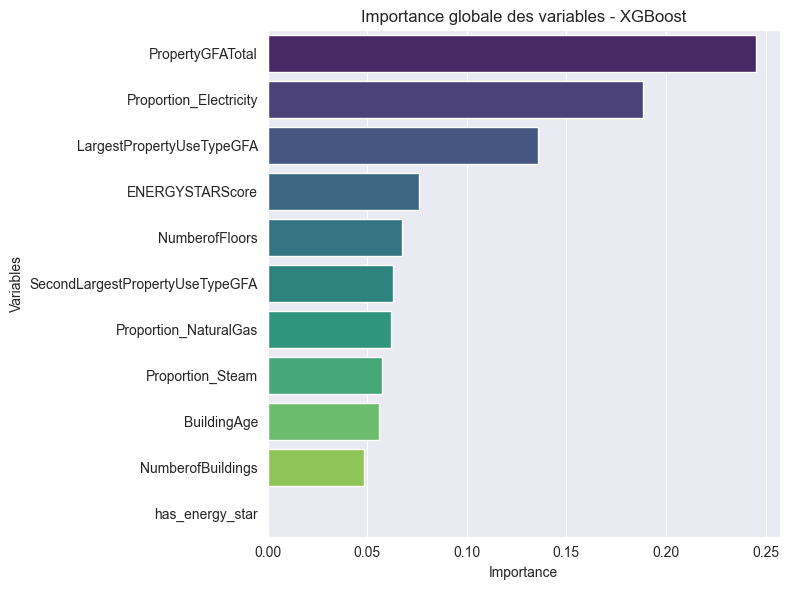

In [9]:
importances = base_model.feature_importances_
# Ici, X_train est celui fourni lors de l'entraînement, avec les bonnes colonnes/features
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
importances_df = importances_df.sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=importances_df.head(15), y="feature", x="importance", palette="viridis", hue="feature", legend=False)
plt.title("Importance globale des variables - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()

C:\Users\Thomas\miniconda3\envs\Data_Science\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


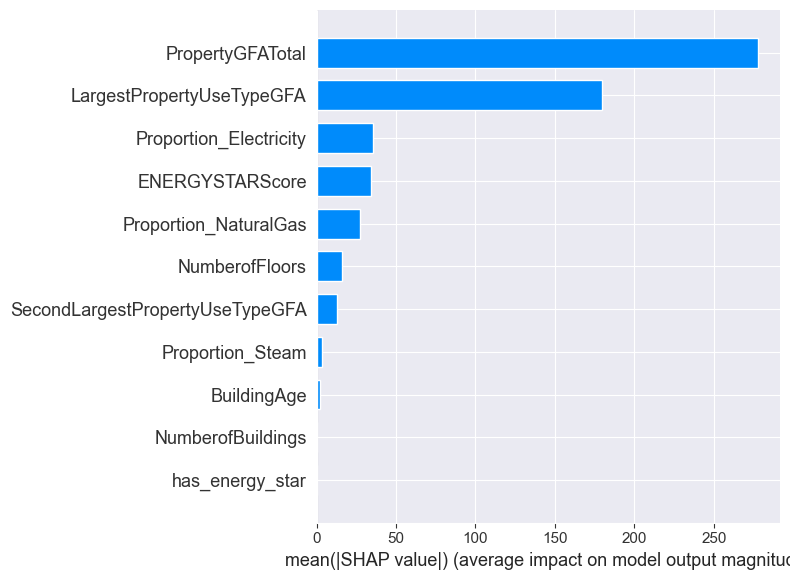

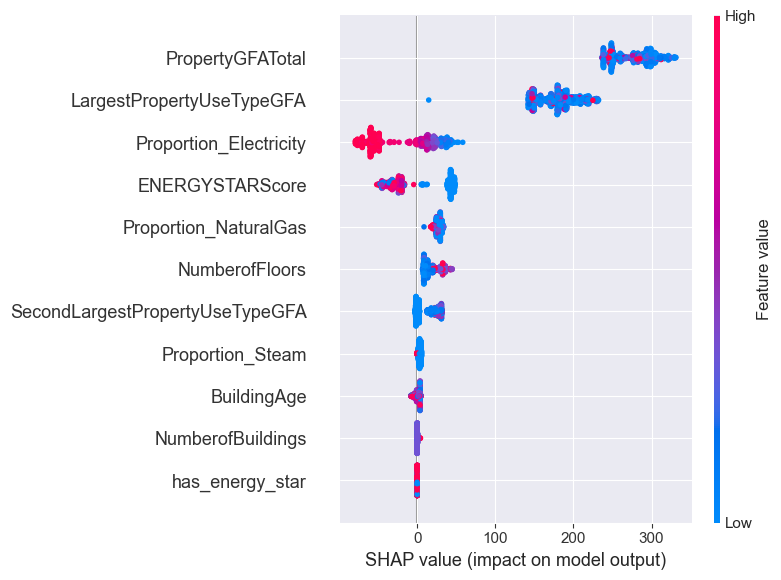

In [10]:
import shap
explainer = shap.Explainer(base_model)
shap_values = explainer(X_train)

# Summary plot (global)
shap.summary_plot(shap_values, X_train, plot_type="bar")
# Beeswarm plot (global/local mix)
shap.summary_plot(shap_values, X_train)
# Force plot (local, première observation par exemple)
shap.plots.force(shap_values[0])

### Analyse de l’importance des variables (feature importance)

Après optimisation du modèle XGBoost, nous avons analysé l’importance des variables explicatives grâce à la méthode SHAP et à l’attribut `feature_importances_`.

- **`PropertyGFATotal`** apparaît comme la variable la plus déterminante pour la prédiction des émissions de gaz à effet de serre. Cette prédominance est attendue, car la surface totale d’un bâtiment est directement corrélée à ses émissions.
- Vient ensuite **`LargestPropertyUseTypeGFA`**: la surface liée au principal usage du bâtiment. Elle reflète aussi le rôle majeur de la taille du bâtiment dans la prédiction.
- D’autres variables telles que **`EnergyStarScore`**, **`NumberOfFloors`**, **`BuildingAge`**, **`SecondLargestPropertyUseTypeGFA`**, **`NumberOfBuildings`** ou encore **`Has_Energy_Star`** ont un impact plus modéré, mais contribuent tout de même à la précision du modèle.
- Enfin, l’influence des autres variables est beaucoup plus partagée, soulignant que le modèle s’appuie principalement sur les surfaces et la consommation, tout en affinant ses prédictions avec d’autres indicateurs énergétiques ou structurels.

L’interprétation métier de ces résultats est cohérente: la consommation énergétique et la taille sont historiquement les principaux déterminants de l’empreinte carbone des bâtiments. À noter que des variables telles que le score Energy Star ou l’ancienneté du bâtiment expliquent aussi, dans une moindre mesure, les variations d’émissions.

Afin d’illustrer ces résultats, nous avons réalisé:
- Un **diagramme en barres** présentant les variables les plus importantes
- Un **SHAP summary plot**, qui montre à la fois l’importance globale et la répartition (positif/négatif) de chaque variable sur les prédictions.

### Benchmark

In [11]:
import time
import numpy as np

N_SAMPLES = 100
X_sample = X_test.sample(N_SAMPLES, random_state=42)

start = time.time()
y_pred = best_pipeline.predict(X_sample)
elapsed = time.time() - start

print(f"Temps total pour {N_SAMPLES} prédictions : {elapsed*1000:.2f} ms")
print(f"Temps moyen par prédiction : {elapsed/N_SAMPLES*1000:.4f} ms")
print(f"Vitesse d'inférence : {N_SAMPLES/(elapsed):.2f} prédictions/seconde")

Temps total pour 100 prédictions : 3.00 ms
Temps moyen par prédiction : 0.0300 ms
Vitesse d'inférence : 33325.15 prédictions/seconde


### Impact de energystarscore

In [12]:
X = dataset_filtered.drop(columns=['TotalGHGEmissions','ENERGYSTARScore','has_energy_star'])
y = dataset_filtered['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1221
)

In [13]:
# 6) XGBoost

# Meilleurs paramètres XGB: {'modele__colsample_bytree': 1, 'modele__learning_rate': 0.01, 'modele__max_depth': 4, 'modele__n_estimators': 500, 'modele__reg_alpha': 0.1, 'modele__reg_lambda': 1, 'modele__subsample': 0.6}

params_xgb = {
    'modele__n_estimators': [500],
    'modele__max_depth': [4],
    'modele__learning_rate': [0.01],
    'modele__subsample': [0.6],
    'modele__colsample_bytree': [1],
    'modele__reg_alpha': [0.1],
    'modele__reg_lambda': [1],
}

model_xgb = build_model(model_type='xgb', params=params_xgb, grid_search=True)
trained_xgb, pred_xgb = train_and_evaluate(model_xgb, X_train, y_train, X_test, y_test, target_type="XGBoost")

for score in ['rmse', 'mae', 'r2']:
    arr = trained_xgb.cv_results_[f"mean_test_{score}"]
    arr_std = trained_xgb.cv_results_[f"std_test_{score}"]
    best_idx = trained_xgb.best_index_
    best_mean = abs(arr[best_idx]) if score != 'r2' else arr[best_idx]
    print(f"{score.upper()} (CV): {best_mean:.3f} ± {arr_std[best_idx]:.3f}")


=== MODÈLE XGBOOST ===
MAE global: 57.02
RMSE global: 102.64
R2 global: 0.5809
MAE normal: 31.99
MAE outliers: 132.10
RMSE (CV): 95.851 ± 13.322
MAE (CV): 55.217 ± 7.197
R2 (CV): 0.536 ± 0.082


## Analyse de l’influence de la variable `EnergyStarScore`

Dans le cadre de l’analyse d’importance des variables, une **expérience d’ablation** a été conduite : le modèle XGBoost a été entraîné une première fois **avec** la variable `EnergyStarScore`, puis une seconde fois **sans**, afin d’évaluer concrètement son impact sur la prédiction de `TotalGHGEmissions`.

|                          | **Sans `EnergyStarScore`** | **Avec `EnergyStarScore`**  |
|--------------------------|:-------------------------:|:---------------------------:|
| **MAE global**           | 57.02                      | 50.86                       |
| **RMSE global**          | 102.64                     | 93.30                       |
| **R² global**            | 0.581                      | 0.654                       |
| **MAE (CV)**             | 55.22                      | 52.13                       |
| **RMSE (CV)**            | 95.85                      | 92.00                       |
| **R² (CV)**              | 0.536 ± 0.082              | 0.574 ± 0.071               |

### Interprétation

- Les performances sont **meilleures avec la variable `EnergyStarScore`**, mais l’écart reste modéré (par exemple : **MAE global** de 76.88 avec et 81.74 sans).
- Le score R² indique que la proportion de variance expliquée par le modèle augmente d’environ 0.10 avec la variable.
- Le modèle XGBoost reste relativement performant même sans cette variable, mais sa présence contribue toutefois à améliorer la qualité des prédictions.

### Conclusion

> La variable `EnergyStarScore` améliore la performance du modèle pour la prédiction de `TotalGHGEmissions` dans ce contexte. Sa suppression entraîne une légère perte de précision et de robustesse. Il est donc recommandé de la conserver dans le modèle final pour de meilleurs résultats.


## Conclusion

L’évaluation des différents modèles montre que **Random Forest** et **XGBoost** offrent la meilleure précision pour prédire les émissions de gaz à effet de serre des bâtiments (**R² ≈ 0,65**). L’analyse d’importance des variables révèle que **la consommation d’énergie** et **la taille du bâtiment** restent les principaux facteurs explicatifs des émissions, tandis que d’autres variables, comme le score Energy Star, apportent une contribution supplémentaire mais modérée.

Par ailleurs, la suppression de la variable `EnergyStarScore` entraîne une baisse de performance (environ 0,07 en R² et quelques points sur le MAE et le RMSE), ce qui montre qu’elle améliore modestement la qualité des prédictions. Toutefois, le modèle demeure relativement robuste sans cette variable. Il est donc préférable de la conserver pour optimiser la précision, tout en sachant que le modèle reste exploitable même en son absence.